# Monte Carlo Portfolio Risk Analysis - My portfolio template 

This notebook provides:
- Portfolio weights calculation (real holdings vs theoretical)
- Monte Carlo simulation with 100,000 scenarios
- Comprehensive risk metrics (VaR, CVaR, Sharpe ratio, etc.)
- Correlation and volatility analysis
- Optimal portfolio allocation recommendations
- Extensive statistical output

## 1. Setup & Configuration

In [117]:
# Install required packages
%pip install yfinance pandas numpy matplotlib scipy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [118]:
# Import libraries
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from scipy import stats
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore') 

print("Libraries loaded successfully")

Libraries loaded successfully


## 2. Portfolio Configuration

In [119]:
# Portfolio tickers
PORTFOLIO_TICKERS = {
    'NOVO-B.CO': 'Novo Nordisk (DKK)',       
    'MC.PA': 'LVMH (EUR)',
    'BNP.PA': 'BNP Paribas (EUR)', 
    'AMUN.PA': 'Amundi (EUR)',
    'FR0011550185': 'S&P500 ETF (EUR)',     
    'FR0013380607': 'CAC40 ETF (EUR)',       
    'AIR.PA': 'Airbus (EUR)'
}

# Extract ticker list
stock_tickers = list(PORTFOLIO_TICKERS.keys())

print(f"Total stocks: {len(stock_tickers)}")
print()
for ticker, description in PORTFOLIO_TICKERS.items():
    print(f"   {ticker:<16} → {description}")

# Fetching current prices (snapshot)
latest_data = yf.download(stock_tickers, period='1d', progress=False)
latest_prices_raw = latest_data['Close'].iloc[-1]

# DKK/EUR exchange rate for currency conversion of Danish stocks (with fallback)
dkk_eur_rate = None
dkk_eur_data = yf.download('DKKEUR=X', period='5d', progress=False)
if not dkk_eur_data.empty and 'Close' in dkk_eur_data.columns:
    dkk_eur_rate = float(dkk_eur_data['Close'].dropna().iloc[-1])
else:
    # Fallback approximate rate if download failed
    dkk_eur_rate = 0.1340
print(f"\n   Live DKK/EUR exchange rate: {dkk_eur_rate:.4f}")

# Build and display current EUR prices snapshot (reuse later to avoid refetch)
CURRENT_PRICES_EUR = {}
print("Current Share Prices (converted to EUR):")
for ticker in stock_tickers:
    display_name = PORTFOLIO_TICKERS[ticker].split(' (')[0]  
    raw_price = latest_prices_raw[ticker] if len(stock_tickers) > 1 else latest_prices_raw
    if ticker.endswith('.CO'): 
        eur_price = raw_price * dkk_eur_rate
    else:
        eur_price = raw_price
    CURRENT_PRICES_EUR[ticker] = eur_price
    print(f"   {display_name:<20}: €{eur_price:>6.2f}")

Total stocks: 7

   NOVO-B.CO        → Novo Nordisk (DKK)
   MC.PA            → LVMH (EUR)
   BNP.PA           → BNP Paribas (EUR)
   AMUN.PA          → Amundi (EUR)
   FR0011550185     → S&P500 ETF (EUR)
   FR0013380607     → CAC40 ETF (EUR)
   AIR.PA           → Airbus (EUR)

   Live DKK/EUR exchange rate: 0.1339
Current Share Prices (converted to EUR):
   Novo Nordisk        : € 43.48
   LVMH                : €458.60
   BNP Paribas         : € 80.19
   Amundi              : € 65.40
   S&P500 ETF          : € 27.49
   CAC40 ETF           : € 38.04
   Airbus              : €178.52


In [120]:
# Number of shares you own for each ticker
YOUR_HOLDINGS = {
    'NOVO-B.CO':15,      # Number of Novo Nordisk shares you own
    'MC.PA': 3,          # Number of LVMH shares you own
    'BNP.PA': 14,        # Number of BNP Paribas shares you own
    'AMUN.PA': 10,       # Number of Amundi shares you own
    'FR0011550185': 12,  # S&P500 ETF shares (BNP Paribas Easy S&P 500 UCITS ETF)
    'FR0013380607': 15,  # CAC40 ETF shares (Amundi CAC 40 UCITS ETF Acc)
    'AIR.PA': 1          # Number of Airbus shares you own
}

# Monte Carlo simulation parameters
SIMULATION_DAYS = 252        # Number of trading days 
NUM_SIMULATIONS = 100000    # Number of Monte Carlo scenarios
INITIAL_INVESTMENT = 4447    # Use actual current portfolio value 
HISTORICAL_DAYS = 365*4 # Number of historical days to use 
CONFIDENCE_LEVEL = 0.05      # 5% for 95% confidence VaR/CVaR
RISK_FREE_RATE = 0.03       # 3% annual risk-free rate

print(f"Portfolio Configuration:")
print(f"   Stocks: {len(stock_tickers)}")
print(f"   Simulation days: {SIMULATION_DAYS}")
print(f"   Monte Carlo runs: {NUM_SIMULATIONS:,}")
print(f"   Initial investment: €{INITIAL_INVESTMENT:,}")
print(f"   Historical data: {HISTORICAL_DAYS} days")

Portfolio Configuration:
   Stocks: 7
   Simulation days: 252
   Monte Carlo runs: 100,000
   Initial investment: €4,447
   Historical data: 1460 days


## 3. Data Download & Preprocessing

Historical Data Summary:
   Date range: 2021-08-10 to 2025-08-08
   Trading days: 1029
   Mean daily returns:
     Novo Nordisk   :  0.000346 (  8.7% annual)
     LVMH           : -0.000161 ( -4.1% annual)
     BNP Paribas    :  0.000826 ( 20.8% annual)
     Amundi         :  0.000190 (  4.8% annual)
     S&P500 ETF     :  0.000457 ( 11.5% annual)
     CAC40 ETF      :  0.000291 (  7.3% annual)
     Airbus         :  0.000644 ( 16.2% annual)


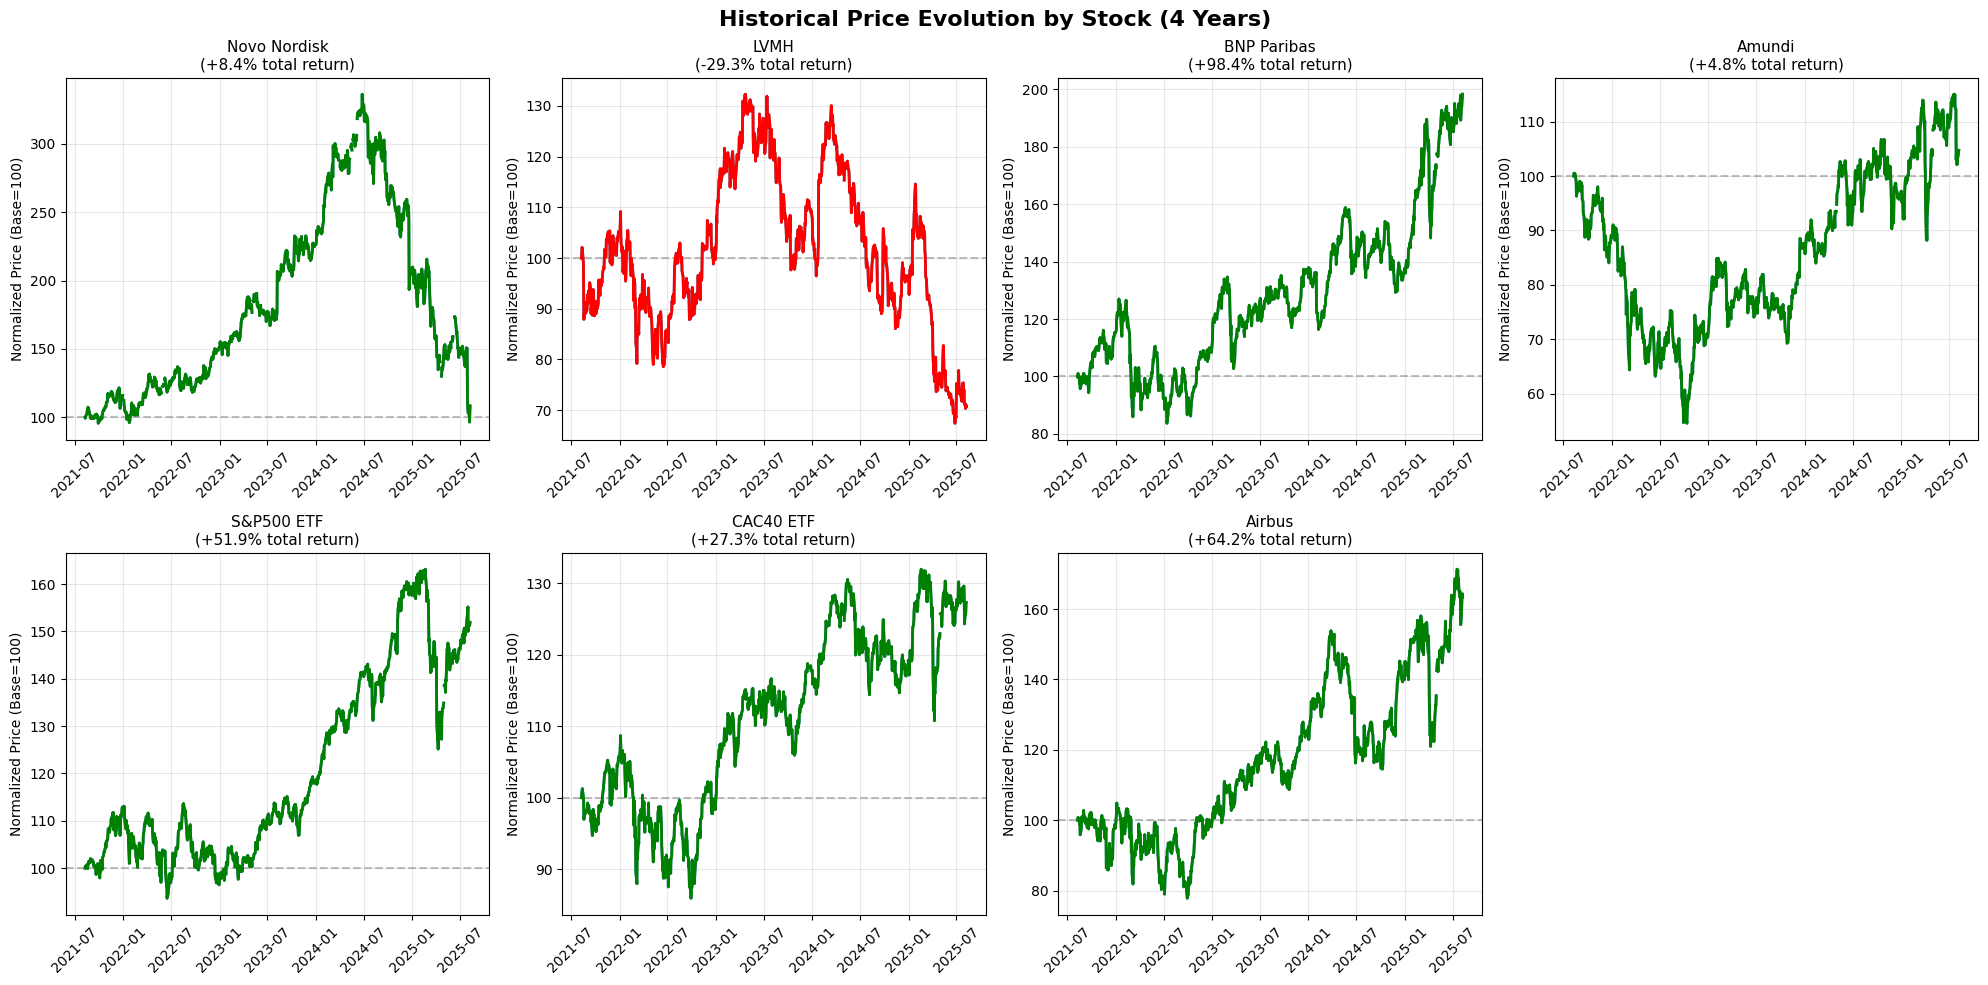

In [121]:
def download_stock_data(tickers, start_date, end_date):
    """
    Download stock data and calculate returns and covariance matrix
    
    Parameters:
    - tickers: List of stock tickers
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - returns: Daily returns DataFrame
    - mean_returns: Mean daily returns Series
    - cov_matrix: Covariance matrix DataFrame
    - historical_data: DataFrame with historical prices
    """
    
    # Download data
    stock_data = yf.download(tickers, start=start_date, end=end_date, 
                           progress=False, auto_adjust=True)
    
    # Extract closing prices
    if len(tickers) == 1:
        close_prices = stock_data['Close'].to_frame()
        close_prices.columns = tickers
    else:
        close_prices = stock_data['Close']
    
    # Calculate daily returns
    returns = close_prices.pct_change().dropna()
    
    # Calculate statistics
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    return returns, mean_returns, cov_matrix

# Download historical data using HISTORICAL_DAYS parameter
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=HISTORICAL_DAYS)

returns, mean_returns, cov_matrix = download_stock_data(stock_tickers, start_date, end_date)

# Display summary statistics
print(f"Historical Data Summary:")
print(f"   Date range: {returns.index[0].strftime('%Y-%m-%d')} to {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"   Trading days: {len(returns)}")
print(f"   Mean daily returns:")
for ticker in stock_tickers:
    # Get the company name from PORTFOLIO_TICKERS, removing currency info
    company_name = PORTFOLIO_TICKERS[ticker].split(' (')[0]
    daily_return = mean_returns[ticker]
    annual_return = daily_return * 252
    # Use more precision for very small returns
    if abs(daily_return) < 0.000001:
        print(f"     {company_name:<15}: {daily_return:9.8f} ({annual_return:6.3%} annual)")
    else:
        print(f"     {company_name:<15}: {daily_return:9.6f} ({annual_return:6.1%} annual)")

# Visualize price evolution for each stock
stock_data_viz = yf.download(stock_tickers, start=start_date, end=end_date, 
                           progress=False, auto_adjust=True)

if len(stock_tickers) == 1:
    close_prices_viz = stock_data_viz['Close'].to_frame()
    close_prices_viz.columns = stock_tickers
else:
    close_prices_viz = stock_data_viz['Close']

# Create subplots for each stock
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Historical Price Evolution by Stock (4 Years)', fontsize=16, fontweight='bold')
axes = axes.flatten()  # Flatten for easier indexing

for i, ticker in enumerate(stock_tickers):
    ax = axes[i]
    company_name = PORTFOLIO_TICKERS[ticker].split(' (')[0]
    
    # Plot normalized price evolution (starting at 100)
    normalized_prices = (close_prices_viz[ticker] / close_prices_viz[ticker].iloc[0]) * 100
    ax.plot(normalized_prices.index, normalized_prices, linewidth=2, label=company_name)
    
    # Add horizontal line at 100 (starting point)
    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='Starting Point')
    
    # Calculate total return for the period
    total_return = (normalized_prices.iloc[-1] / 100 - 1) * 100
    
    ax.set_title(f'{company_name}\n({total_return:+.1f}% total return)', fontsize=11)
    ax.set_ylabel('Normalized Price (Base=100)')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Color the line based on performance
    if total_return > 0:
        ax.plot(normalized_prices.index, normalized_prices, color='green', linewidth=2)
    else:
        ax.plot(normalized_prices.index, normalized_prices, color='red', linewidth=2)

# Hide the empty subplot
if len(stock_tickers) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

## 4. Portfolio Weights Calculation

Portfolio Analysis:
Stock                Shares   Price (EUR)  Value        Weight  
---------------------------------------------------------------------------
Novo Nordisk         15       €43.48       €652         13.4%  
LVMH                 3        €458.60      €1,376       28.2%  
BNP Paribas          14       €80.19       €1,123       23.0%  
Amundi               10       €65.40       €654         13.4%  
S&P500 ETF           12       €27.49       €330         6.8%   
CAC40 ETF            15       €38.04       €571         11.7%  
Airbus               1        €178.52      €179         3.7%   
---------------------------------------------------------------------------
TOTAL                                      €4,884               


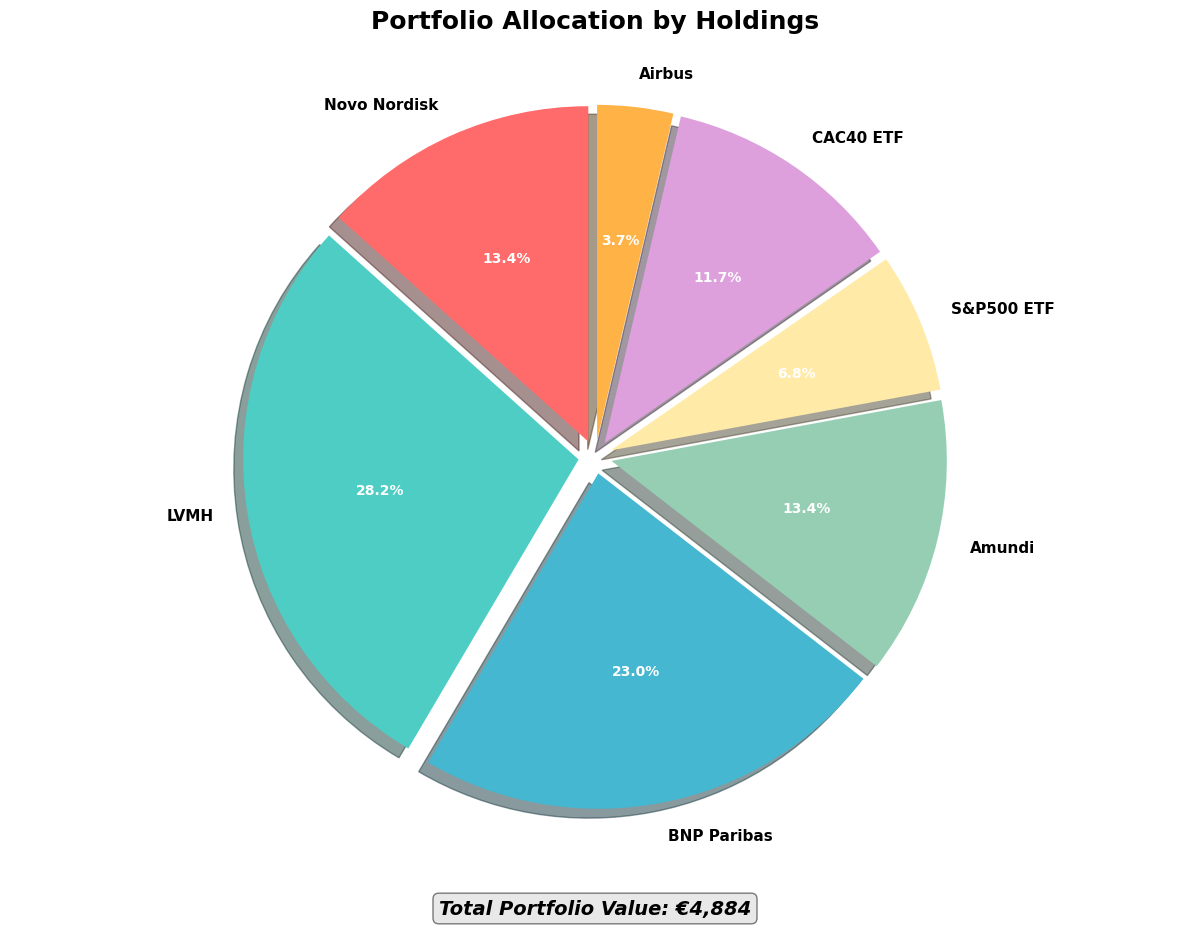

In [122]:
def calculate_portfolio_weights(holdings_dict, current_prices=CURRENT_PRICES_EUR):
    """
    Calculate portfolio weights based on current holdings and market prices
    Uses pre-fetched EUR prices from portfolio configuration
    
    Parameters:
    - holdings_dict: Dictionary with ticker: number_of_shares
    - current_prices: Dictionary of current stock prices in EUR
    
    Returns:
    - weights: Array of portfolio weights
    - market_values: Dictionary of market values by stock
    - total_value: Total portfolio value
    """
    # Calculate market values using existing EUR prices
    market_values = {}
    total_value = 0

    print(f"Portfolio Analysis:")
    print(f"{'Stock':<20} {'Shares':<8} {'Price (EUR)':<12} {'Value':<12} {'Weight':<8}")
    print("-" * 75)
    
    for ticker in stock_tickers:
        shares = holdings_dict.get(ticker, 0)
        price_eur = current_prices[ticker]
        market_value = shares * price_eur
        market_values[ticker] = market_value
        total_value += market_value
    
    # Calculate and display weights
    weights = np.zeros(len(stock_tickers))
    for i, ticker in enumerate(stock_tickers):
        if total_value > 0:
            weight = market_values[ticker] / total_value
            weights[i] = weight
        else:
            weight = 0
        
        # Get company name from PORTFOLIO_TICKERS, removing currency info
        company_name = PORTFOLIO_TICKERS[ticker].split(' (')[0]
        shares = holdings_dict.get(ticker, 0)
        price_eur = current_prices[ticker]
        currency_note = "(from DKK)" if ticker.endswith('.CO') else ""
        print(f"{company_name:<20} {shares:<8.0f} €{price_eur:<11.2f} €{market_values[ticker]:<11,.0f} {weight:<7.1%}")
    
    print("-" * 75)
    print(f"{'TOTAL':<20} {'':<8} {'':<12} €{total_value:<11,.0f} {'':<8}")
    
    return weights, market_values, total_value

# Output the portfolio weights using the pre-fetched EUR prices
weights, market_values, total_portfolio_value = calculate_portfolio_weights(YOUR_HOLDINGS)

# Create a beautiful pie chart showing portfolio allocation
significant_weights = []
significant_names = []

# Dynamic color generation 
import matplotlib.cm as cm
import numpy as np

for i, ticker in enumerate(stock_tickers):
    if weights[i] > 0.005:  
        company_name = PORTFOLIO_TICKERS[ticker].split(' (')[0]
        significant_weights.append(weights[i])
        significant_names.append(company_name)

# Colors
n_colors = len(significant_weights)
if n_colors <= 7:
    # Use predefined nice colors for small portfolios
    base_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#FFB347']
    colors = base_colors[:n_colors]
else:
    # Generate colors automatically using colormap for larger portfolios
    colors = cm.Set3(np.linspace(0, 1, n_colors))

# Pie chart with better spacing
plt.figure(figsize=(12, 10))  # Slightly larger figure
wedges, texts, autotexts = plt.pie(significant_weights, 
                                  labels=significant_names, 
                                  autopct='%1.1f%%',
                                  colors=colors,
                                  startangle=90,
                                  explode=[0.05] * len(significant_weights),  # Slightly separate slices
                                  shadow=True,
                                  textprops={'fontsize': 11, 'fontweight': 'bold'})

# Enhancing the appearance
plt.title('Portfolio Allocation by Holdings', fontsize=18, fontweight='bold', pad=30)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Output pie chart

plt.figtext(0.5, 0.08, f'Total Portfolio Value: €{total_portfolio_value:,.0f}', 
            ha='center', fontsize=14, style='italic', fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.5))

plt.axis('equal')  
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  
plt.show()



## 5. Portfolio Statistics & Risk Metrics

In [123]:
# Calculate portfolio statistics
def calculate_portfolio_stats(weights, mean_returns, cov_matrix):
    """
    Calculate comprehensive portfolio statistics
    """
    # Annualized metrics
    portfolio_return = np.sum(weights * mean_returns) * 252
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_volatility = np.sqrt(portfolio_variance) * np.sqrt(252)
    
    # Risk metrics
    sharpe_ratio = (portfolio_return - RISK_FREE_RATE) / portfolio_volatility
    
    return portfolio_return, portfolio_volatility, sharpe_ratio

# Individual stock statistics
annual_returns = mean_returns * 252
annual_volatility = np.sqrt(np.diag(cov_matrix)) * np.sqrt(252)

print(f"{'Stock':<12} {'Annual Return':<15} {'Annual Volatility':<18} {'Sharpe Ratio':<12}")
print("-" * 65)
for i, ticker in enumerate(stock_tickers):
    individual_sharpe = (annual_returns[ticker] - RISK_FREE_RATE) / annual_volatility[i]
    print(f"{ticker:<12} {annual_returns[ticker]:>13.1%} {annual_volatility[i]:>16.1%} {individual_sharpe:>10.2f}")

# Portfolio statistics
portfolio_return, portfolio_volatility, portfolio_sharpe = calculate_portfolio_stats(weights, mean_returns, cov_matrix)

print()
print(f" PORTFOLIO STATISTICS")
print("-" * 30)
print(f"Expected Annual Return:     {portfolio_return:7.1%}")
print(f"Annual Volatility:          {portfolio_volatility:7.1%}")
print(f"Sharpe Ratio:               {portfolio_sharpe:7.2f}")
print(f"Risk-Free Rate:             {RISK_FREE_RATE:7.1%}")

# Diversification benefit
weighted_avg_volatility = np.sum(weights * annual_volatility)
diversification_benefit = weighted_avg_volatility - portfolio_volatility
print()
print(f"DIVERSIFICATION ANALYSIS")
print("-" * 30)
print(f"Weighted average volatility: {weighted_avg_volatility:6.1%}")
print(f"Portfolio volatility:        {portfolio_volatility:6.1%}")
print(f"Diversification benefit:     {diversification_benefit:6.1%}")
print(f"Diversification ratio:       {(diversification_benefit/weighted_avg_volatility)*100:5.1f}%")

Stock        Annual Return   Annual Volatility  Sharpe Ratio
-----------------------------------------------------------------
NOVO-B.CO             8.7%            28.5%       0.20
MC.PA                -4.1%            27.0%      -0.26
BNP.PA               20.8%            28.4%       0.63
AMUN.PA               4.8%            16.0%       0.11
FR0011550185         11.5%            16.8%       0.51
FR0013380607          7.3%            29.9%       0.14
AIR.PA               16.2%            36.2%       0.37

 PORTFOLIO STATISTICS
------------------------------
Expected Annual Return:       10.2%
Annual Volatility:            20.2%
Sharpe Ratio:                  0.36
Risk-Free Rate:                3.0%

DIVERSIFICATION ANALYSIS
------------------------------
Weighted average volatility:  26.0%
Portfolio volatility:         20.2%
Diversification benefit:       5.8%
Diversification ratio:        22.4%


## 6. Monte Carlo Simulation (KPIs + Visual)

🎲 Running Monte Carlo simulation...
   Scenarios: 100,000
   Time horizon: 252 days


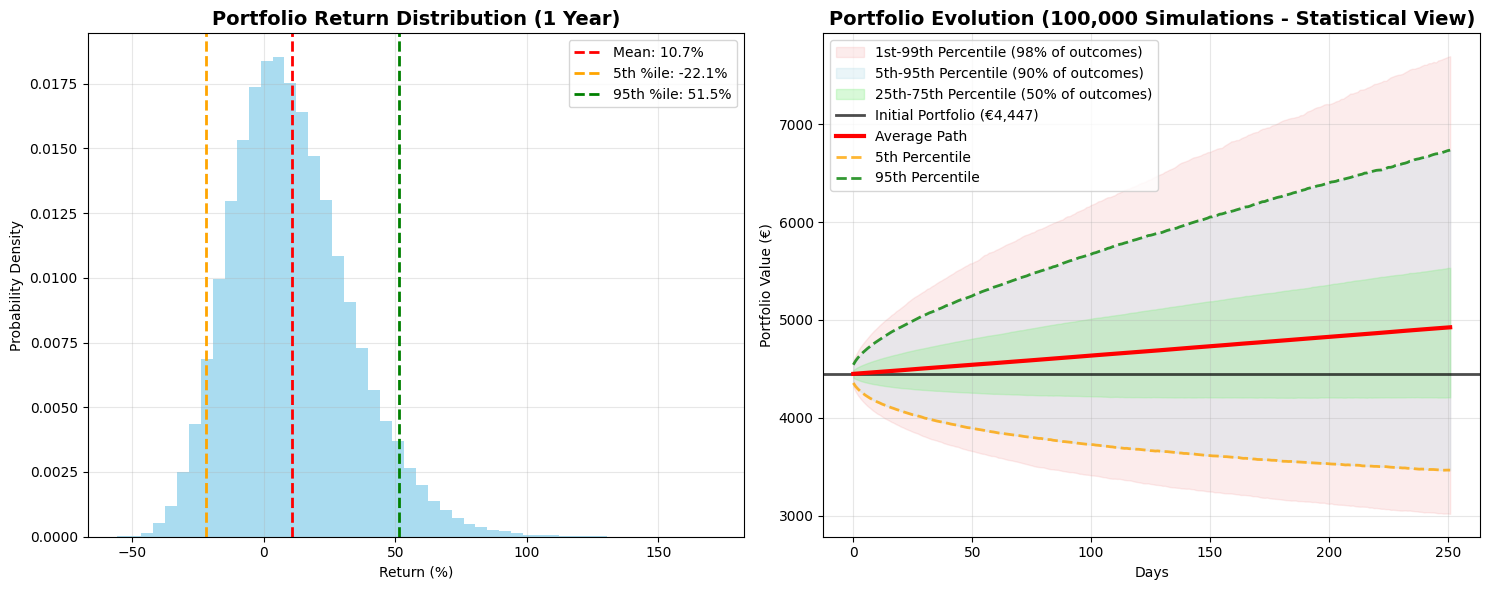

In [124]:
def run_monte_carlo_simulation(weights, mean_returns, cov_matrix, 
                              num_simulations=NUM_SIMULATIONS, 
                              time_horizon=SIMULATION_DAYS):
    """
    Run Monte Carlo simulation for portfolio returns
    
    Returns:
    - portfolio_sims: Array of simulated portfolio values over time
    """
    print(f"🎲 Running Monte Carlo simulation...")
    print(f"   Scenarios: {num_simulations:,}")
    print(f"   Time horizon: {time_horizon} days")
    
    # Prepare mean returns matrix
    mean_matrix = np.full(shape=(len(weights), time_horizon), 
                         fill_value=mean_returns.values.reshape(-1, 1))
    
    # Initialize results array
    portfolio_sims = np.full(shape=(time_horizon, num_simulations), fill_value=0.0)
    
    # Cholesky decomposition for correlated random returns
    L = np.linalg.cholesky(cov_matrix)
    
    # Run simulations (completely silent)
    for m in range(num_simulations):
        # Generate correlated random returns
        Z = np.random.normal(size=(len(weights), time_horizon))
        daily_returns = mean_matrix + np.dot(L, Z)
        
        # Calculate portfolio returns
        portfolio_returns = np.dot(weights, daily_returns)
        
        # Calculate cumulative returns (portfolio value evolution)
        portfolio_sims[:, m] = np.cumprod(1 + portfolio_returns)
    
    # Calculate key metrics
    final_values_eur = portfolio_sims[-1] * INITIAL_INVESTMENT
    returns_pct = (final_values_eur / INITIAL_INVESTMENT - 1) * 100
    
    # Create distribution chart
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Returns distribution
    ax1.hist(returns_pct, bins=50, alpha=0.7, color='skyblue', density=True)
    ax1.axvline(returns_pct.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {returns_pct.mean():.1f}%')
    ax1.axvline(np.percentile(returns_pct, 5), color='orange', linestyle='--', linewidth=2, label=f'5th %ile: {np.percentile(returns_pct, 5):.1f}%')
    ax1.axvline(np.percentile(returns_pct, 95), color='green', linestyle='--', linewidth=2, label=f'95th %ile: {np.percentile(returns_pct, 95):.1f}%')
    ax1.set_title('Portfolio Return Distribution (1 Year)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Return (%)')
    ax1.set_ylabel('Probability Density')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Portfolio evolution with statistical bands (optimized visualization)
    portfolio_eur = portfolio_sims * INITIAL_INVESTMENT
    
    # Calculate key percentiles for statistical representation
    p01 = np.percentile(portfolio_eur, 1, axis=1)   # 1st percentile (worst 1%)
    p05 = np.percentile(portfolio_eur, 5, axis=1)   # 5th percentile  
    p25 = np.percentile(portfolio_eur, 25, axis=1)  # 25th percentile
    p75 = np.percentile(portfolio_eur, 75, axis=1)  # 75th percentile
    p95 = np.percentile(portfolio_eur, 95, axis=1)  # 95th percentile
    p99 = np.percentile(portfolio_eur, 99, axis=1)  # 99th percentile (best 1%)
    mean_path = np.mean(portfolio_eur, axis=1)      # Average path
    
    days = range(len(mean_path))
    
    # Create layered confidence bands
    ax2.fill_between(days, p01, p99, alpha=0.15, color='lightcoral', label='1st-99th Percentile (98% of outcomes)')
    ax2.fill_between(days, p05, p95, alpha=0.25, color='lightblue', label='5th-95th Percentile (90% of outcomes)')
    ax2.fill_between(days, p25, p75, alpha=0.35, color='lightgreen', label='25th-75th Percentile (50% of outcomes)')
    
    # Add initial portfolio value reference line
    ax2.axhline(y=INITIAL_INVESTMENT, color='black', linewidth=2, linestyle='-', alpha=0.7, label=f'Initial Portfolio (€{INITIAL_INVESTMENT:,.0f})')
    
    # Add mean and key percentile lines
    ax2.plot(days, mean_path, color='red', linewidth=3, label='Average Path')
    ax2.plot(days, p05, color='orange', linewidth=2, linestyle='--', alpha=0.8, label='5th Percentile')
    ax2.plot(days, p95, color='green', linewidth=2, linestyle='--', alpha=0.8, label='95th Percentile')
    
    ax2.set_title('Portfolio Evolution (100,000 Simulations - Statistical View)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Days')
    ax2.set_ylabel('Portfolio Value (€)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return portfolio_sims

# Run the simulation
portfolio_simulations = run_monte_carlo_simulation(weights, mean_returns, cov_matrix)


## 7. Risk Analysis & Statistics (deeper insights)

In [125]:
def calculate_comprehensive_risk_metrics(portfolio_sims, initial_investment=INITIAL_INVESTMENT):
    """
    Calculate comprehensive risk metrics from Monte Carlo results
    """
    # Final portfolio values
    final_values = portfolio_sims[-1, :] * initial_investment
    returns_pct = (final_values / initial_investment - 1) * 100
    
    # Basic statistics
    mean_final_value = final_values.mean()
    median_final_value = np.median(final_values)
    std_final_value = final_values.std()
    
    # Return statistics
    mean_return = returns_pct.mean()
    median_return = np.median(returns_pct)
    std_return = returns_pct.std()
    
    # Risk metrics
    losses = initial_investment - final_values
    var_95 = np.percentile(losses, 95)
    var_99 = np.percentile(losses, 99)
    
    # CVaR (Expected Shortfall)
    cvar_95 = losses[losses >= var_95].mean()
    cvar_99 = losses[losses >= var_99].mean()
    
    # Probability metrics
    prob_loss = (final_values < initial_investment).mean() * 100
    prob_loss_10 = (returns_pct < -10).mean() * 100
    prob_loss_20 = (returns_pct < -20).mean() * 100
    prob_gain_10 = (returns_pct > 10).mean() * 100
    prob_gain_20 = (returns_pct > 20).mean() * 100
    
    # Percentiles
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    value_percentiles = np.percentile(final_values, percentiles)
    return_percentiles = np.percentile(returns_pct, percentiles)
    
    # Distribution statistics
    skewness = stats.skew(returns_pct)
    kurtosis = stats.kurtosis(returns_pct)
    
    return {
        'final_values': final_values,
        'returns_pct': returns_pct,
        'mean_final_value': mean_final_value,
        'median_final_value': median_final_value,
        'std_final_value': std_final_value,
        'mean_return': mean_return,
        'median_return': median_return,
        'std_return': std_return,
        'var_95': var_95,
        'var_99': var_99,
        'cvar_95': cvar_95,
        'cvar_99': cvar_99,
        'prob_loss': prob_loss,
        'prob_loss_10': prob_loss_10,
        'prob_loss_20': prob_loss_20,
        'prob_gain_10': prob_gain_10,
        'prob_gain_20': prob_gain_20,
        'value_percentiles': value_percentiles,
        'return_percentiles': return_percentiles,
        'percentile_labels': percentiles,
        'skewness': skewness,
        'kurtosis': kurtosis
    }

# Calculate comprehensive risk metrics
risk_metrics = calculate_comprehensive_risk_metrics(portfolio_simulations)

# Display comprehensive results
print(f"PORTFOLIO VALUE STATISTICS")
print("-" * 35)
print(f"Expected Final Value:        €{risk_metrics['mean_final_value']:>10,.0f}")
print(f"Median Final Value:          €{risk_metrics['median_final_value']:>10,.0f}")
print(f"Standard Deviation:          €{risk_metrics['std_final_value']:>10,.0f}")

print(f"RETURN STATISTICS")
print("-" * 22)
print(f"Expected Return:             {risk_metrics['mean_return']:>9.1f}%")
print(f"Median Return:               {risk_metrics['median_return']:>9.1f}%")
print(f"Return Volatility:           {risk_metrics['std_return']:>9.1f}%")
print(f"Skewness:                    {risk_metrics['skewness']:>9.2f}")
print(f"Kurtosis:                    {risk_metrics['kurtosis']:>9.2f}")

print(f"RISK METRICS")
print("-" * 17)
print(f"Value at Risk (95%):         €{risk_metrics['var_95']:>10,.0f}")
print(f"Value at Risk (99%):         €{risk_metrics['var_99']:>10,.0f}")
print(f"Expected Shortfall (95%):    €{risk_metrics['cvar_95']:>10,.0f}")
print(f"Expected Shortfall (99%):    €{risk_metrics['cvar_99']:>10,.0f}")

print(f"PROBABILITY ANALYSIS")
print("-" * 25)
print(f"Probability of Any Loss:     {risk_metrics['prob_loss']:>8.1f}%")
print(f"Probability of >10% Loss:    {risk_metrics['prob_loss_10']:>8.1f}%")
print(f"Probability of >20% Loss:    {risk_metrics['prob_loss_20']:>8.1f}%")
print(f"Probability of >10% Gain:    {risk_metrics['prob_gain_10']:>8.1f}%")
print(f"Probability of >20% Gain:    {risk_metrics['prob_gain_20']:>8.1f}%")

print(f"\n📊 RETURN DISTRIBUTION PERCENTILES")
print("-" * 35)
for i, pct in enumerate(risk_metrics['percentile_labels']):
    value = risk_metrics['value_percentiles'][i]
    return_pct = risk_metrics['return_percentiles'][i]
    print(f"{pct:2d}th percentile:              €{value:>7,.0f} ({return_pct:>6.1f}%)")

PORTFOLIO VALUE STATISTICS
-----------------------------------
Expected Final Value:        €     4,925
Median Final Value:          €     4,822
Standard Deviation:          €     1,006
RETURN STATISTICS
----------------------
Expected Return:                  10.7%
Median Return:                     8.4%
Return Volatility:                22.6%
Skewness:                         0.62
Kurtosis:                         0.69
RISK METRICS
-----------------
Value at Risk (95%):         €       983
Value at Risk (99%):         €     1,430
Expected Shortfall (95%):    €     1,258
Expected Shortfall (99%):    €     1,623
PROBABILITY ANALYSIS
-------------------------
Probability of Any Loss:         34.4%
Probability of >10% Loss:        17.8%
Probability of >20% Loss:         6.5%
Probability of >10% Gain:        47.2%
Probability of >20% Gain:        31.0%

📊 RETURN DISTRIBUTION PERCENTILES
-----------------------------------
 1th percentile:              €  3,017 ( -32.1%)
 5th percentile:  

## 8. Optimal Portfolio Analysis 

In [126]:
def calculate_realistic_optimal_portfolio(mean_returns, cov_matrix, risk_free_rate=RISK_FREE_RATE):
    """
    Calculate realistic optimal portfolio weights with constraints:
    - No negative weights (no short selling)
    - Maximum 40% in any single stock (concentration limit)
    - Weights must sum to 100%
    """
    try:
        from scipy.optimize import minimize
        
        # Convert to annual returns
        annual_returns = mean_returns * 252
        annual_cov = cov_matrix * 252
        n_assets = len(annual_returns)
        
        # Objective function: maximize Sharpe ratio (minimize negative Sharpe)
        def negative_sharpe(weights):
            portfolio_return = np.dot(weights, annual_returns)
            portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))
            sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
            return -sharpe
        
        # Constraints
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
        ]
        # Bounds: each weight between 0% and 100%
        bounds = [(0.005, 0.3) for _ in range(n_assets)]
        
        # Initial guess: equal weights
        x0 = np.array([1/n_assets] * n_assets)
        
        # Optimize
        result = minimize(negative_sharpe, x0, method='SLSQP', 
                         bounds=bounds, constraints=constraints)
        
        if result.success:
            optimal_weights = result.x
            optimal_return = np.dot(optimal_weights, annual_returns)
            optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(annual_cov, optimal_weights)))
            optimal_sharpe = (optimal_return - risk_free_rate) / optimal_volatility
            
            return optimal_weights, optimal_return, optimal_volatility, optimal_sharpe
        else:
            return None, None, None, None
            
    except ImportError:
        print("⚠️  scipy.optimize not available - using equal weights as baseline")
        equal_weights = np.array([1/len(mean_returns)] * len(mean_returns))
        return equal_weights, None, None, None

# Calculate REALISTIC optimal portfolio

optimal_weights, opt_return, opt_volatility, opt_sharpe = calculate_realistic_optimal_portfolio(mean_returns, cov_matrix)

if optimal_weights is not None:
    print("Realistic optimal allocation:")
    print(f"{'Stock':<15} {'Current':<10} {'Optimal':<10} {'Difference':<12}")
    print("-" * 55)
    
    for i, ticker in enumerate(stock_tickers):
        current_weight = weights[i]
        optimal_weight = optimal_weights[i]
        difference = optimal_weight - current_weight
        print(f"{ticker:<15} {current_weight:>8.1%} {optimal_weight:>8.1%} {difference:>10.1%}")
    
    if opt_return is not None:
        current_return, current_volatility, current_sharpe = calculate_portfolio_stats(weights, mean_returns, cov_matrix)
        print()
        print(f"{'Metric':<20} {'Current':<10} {'Optimal':<10} {'Improvement':<12}")
        print("-" * 60)
        print(f"{'Annual Return':<20} {current_return:>8.1%} {opt_return:>8.1%} {opt_return-current_return:>10.1%}")
        print(f"{'Annual Volatility':<20} {current_volatility:>8.1%} {opt_volatility:>8.1%} {opt_volatility-current_volatility:>10.1%}")
        print(f"{'Sharpe Ratio':<20} {current_sharpe:>8.2f} {opt_sharpe:>8.2f} {opt_sharpe-current_sharpe:>10.2f}")
        
        

Realistic optimal allocation:
Stock           Current    Optimal    Difference  
-------------------------------------------------------
NOVO-B.CO          13.4%    27.7%      14.3%
MC.PA              28.2%     0.5%     -27.7%
BNP.PA             23.0%    30.0%       7.0%
AMUN.PA            13.4%    30.0%      16.6%
FR0011550185        6.8%     0.5%      -6.3%
FR0013380607       11.7%     0.5%     -11.2%
AIR.PA              3.7%    10.8%       7.1%

Metric               Current    Optimal    Improvement 
------------------------------------------------------------
Annual Return           10.2%    15.2%       5.0%
Annual Volatility       20.2%    18.6%      -1.6%
Sharpe Ratio             0.36     0.66       0.30
